In [1]:
#basic library
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

#sklearn library
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.model_selection as ms
from sklearn.linear_model import LogisticRegression

#scipy library
import scipy.stats as stats
import scipy

#worcloud
from wordcloud import WordCloud

# **Dataset Amazon Top 50 Bestselling Books 2009 - 2022**


Il dataset contiene i 50 libri best seller per anno dal 2009 al 2022

Ci chiediamo quindi, per una casa editrice, ad oggi cosa conviene pubblicare per vendere maggiormente su amazon? e con quale prezzo?

Il notebook è strutturato in tre punti principali:
+ il genere preferito dall'utenza
+ la variazione del prezzo 
+ le parole più utilizzate nei nomi

Per prima cosa facciamo qualche operazione preliminare per conoscere meglio il dataset:

In [2]:
book = pd.read_csv('bestsellers_with_categories_2022_03_27.csv') 
book.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17,2009,Non Fiction
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5,2009,Non Fiction
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13,2009,Fiction
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14,2009,Non Fiction
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4,2009,Fiction


Da una lettura preliminare del dataset attraverso la funzione head possiamo già capire che si potrà lavorare ad esempio sul campo "genre" che assume solo due tipi (fiction e non fiction) e capirne la correlazione con gli anni, le valutazioni ecc. ecc.

##### Ragioniamo adesso sul significato di ogni colonna 

- *Name*: il nome del libro (qualitativo)
- *Author*: l'autore del libro (qualitativo)
- *User Rating*: il punteggio di ogni libro
- *Reviews*: il numero di recensioni di quel determinato libro (corrisponde indirettamente a copie vendute)
- *Price*: prezzo del libro
- *Year*: anno di pubblicazione del libro
- *Genre*: genere del libro (valore "booleano" nel senso che può assumere solo due valori)

Estraiamo informazioni di base sul nostro dataset.

In [3]:
book.describe()

,User Rating,Reviews,Price,Year
count,700.000000,700.000000,700.000000,700.000000
mean,4.639857,19255.195714,12.700000,2015.500000
std,0.218586,23613.443875,9.915162,4.034011
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4987.250000,7.000000,2012.000000
50%,4.700000,10284.000000,11.000000,2015.500000
75%,4.800000,23358.000000,15.000000,2019.000000
max,4.900000,208917.000000,105.000000,2022.000000


Attraverso la funzione describe ci accorgiamo ad esempio che il libro più costoso è di 105 euro ma ce ne sono anche altri gratis, cosa che potrebbe essere dovuta ad un riempimento automatico del dataset oppure il libro in una sua edizione è effettivamente gratis

Controllo se ci sono colonne con elementi vuoti, come vedremo non ci sono e quindi non dovrò eseguire funzioni di riempimento automatico

In [4]:
book.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

quanti dati e quante caratteristiche abbiamo a disposizione?

In [5]:
book.shape

(700, 7)

Dall'output della funzione shape capiamo che le colonne sono 7 (informazione già conosciuta) e che il numero di righe e cioè libri nel dataset è 700

Tutte le caratteristiche sono abbastanza significative, anche quelle qualitative come il nome e l'autore e quindi non credo sia necessario eliminare delle colonne

Adesso controlliamo che non ci siano elementi duplicati nel nostro dataset:

In [6]:
book['Name'].describe()

count                                                   700
unique                                                  441
top       Publication Manual of the American Psychologic...
freq                                                     10
Name: Name, dtype: object

Come possiamo vedere sono presenti numerosi libri duplicati nel nostro dataset, per il fatto che un libro è stato bestseller per più anni, o ci sono state diverse edizioni dello stesso libro

Dei nostri 700 elementi solo 441 sono singoli

In [7]:
duplicate_book = book['Name'].describe()['top']
book_is_duplicate = book['Name'] == duplicate_book

In [8]:
filtered_dataframe = book[book_is_duplicate]
filtered_dataframe

,Name,Author,User Rating,Reviews,Price,Year,Genre
22,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2009,Non Fiction
70,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2010,Non Fiction
120,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2011,Non Fiction
170,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2012,Non Fiction
225,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2013,Non Fiction
276,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2014,Non Fiction
329,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2015,Non Fiction
379,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2016,Non Fiction
425,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2017,Non Fiction
479,Publication Manual of the American Psychologic...,American Psychological Association,4.5,8580,46,2018,Non Fiction


Ad esempio questo libro della American Psycological Association è presente ben 10 volte nel dataset, perchè è stato best seller per molti anni consecutivi

Adesso calcoliamo la correlazione tra le feature quantitative del nostro dataset:

In [9]:
book.corr(method='pearson')

,User Rating,Reviews,Price,Year
User Rating,1.000000,0.080423,-0.157253,0.286601
Reviews,0.080423,1.000000,-0.114554,0.494279
Price,-0.157253,-0.114554,1.000000,-0.155266
Year,0.286601,0.494279,-0.155266,1.000000


La correlazione tra dati che si nota maggiormente è quella Reviewes - Year.

Vale la pena quindi capire cosa è successo per far si che la correlazione sia di 0.5

Applicando un semplice grafico lineare si può vedere come proprio tra il 2019 e il 2020 c'è stato un vertiginoso inalzamento delle reviews

In [10]:
annual_reviews = book.groupby('Year')[['Reviews']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_reviews)

    Year   Reviews
0   2009   4710.12
1   2010   5479.62
2   2011   8100.82
3   2012  13090.92
4   2013  13098.14
5   2014  15859.94
6   2015  14233.38
7   2016  14196.00
8   2017  12888.40
9   2018  13930.42
10  2019  15898.34
11  2020  52349.94
12  2021  44859.48
13  2022  40877.22


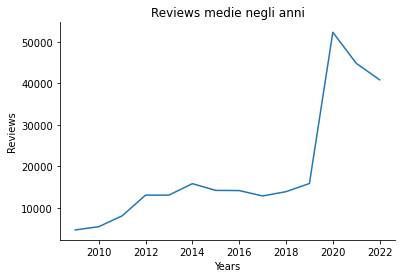

In [11]:
fig, ax = plt.subplots()
plt.plot(annual_reviews['Year'], annual_reviews['Reviews'])
plt.title("Reviews medie negli anni")
plt.ylabel("Reviews")
plt.xlabel("Years")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

<AxesSubplot:title={'center':'Reviews medie negli anni'}, xlabel='Year', ylabel='Reviews'>

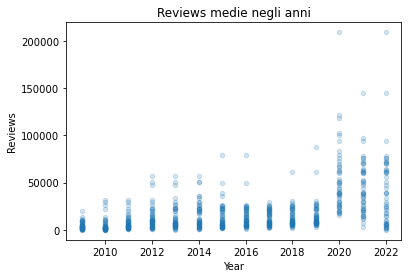

In [12]:
book.plot(kind= 'scatter', x= 'Year', y= 'Reviews', title= 'Reviews medie negli anni', alpha= 0.2)

Questo è un chiaro esempio di come la pandemia ha effettivamente cambiato le abitudini.

A partire infatti dal 2020 c'è un aumento vertiginoso del numero di reviews, che può anche essere legato al numero di copie comprate (dato non presente purtroppo nel dataset)

Come possiamo vedere nel 2019 il numero medio di reviews si aggira attorno alle 8000 mentre nel 2020 il numero medio è 42000

Questo aumento è così improvviso e corposo non può essere ignorato, e deve essere sicuramente collegato ad un evento d'impatto come la pandemia.

Come immaginabile infatti, con la fine del lockdown più pesante nel 2020 il numero di reviews si è, pur restando molto alto, ridimensionato

Una volta fatte queste considerazioni possiamo affermare di aver compreso il nostro dataset e quindi può iniziare lo studio effettivo che ci porta a capire cosa conviene pubblicare ad oggi per vendere di più

## STUDIO SUL GENERE PREFERITO

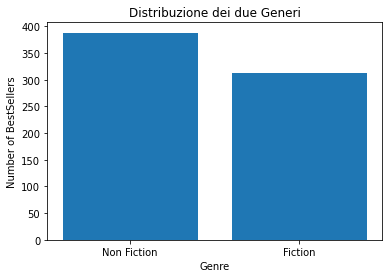

In [13]:
counts = book["Genre"].value_counts()
plt.bar(counts.index,counts.values)
plt.title("Distribuzione dei due Generi")
plt.ylabel("Number of BestSellers")
plt.xlabel("Genre")
plt.show()

([<matplotlib.patches.Wedge at 0x7f04be76aa10>,
 [Text(-0.1866898666921769, 1.0840419243158714, 'Fiction'),
  Text(0.18668986669217674, -1.0840419243158714, 'Non Fiction')],
 [Text(-0.10183083637755103, 0.5912955950813843, '55.4%'),
  Text(0.10183083637755094, -0.5912955950813843, '44.6%')])

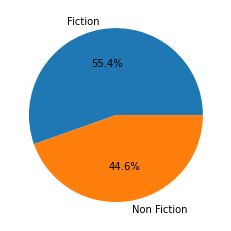

In [14]:
plt.pie(book['Genre'].value_counts(),labels=['Fiction','Non Fiction'],autopct='%.1f%%')

Come possiamo vedere dai grafici c'è una predominanza (anche se leggera) del genere "Non Fiction" rispetto a quello fiction

[Text(0.5, 1.0, 'genre distribution')]

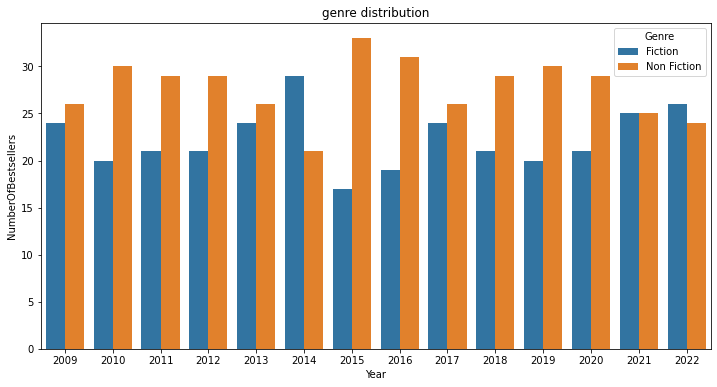

In [15]:
df=book.groupby(['Genre', 'Year']).size().reset_index(name='NumberOfBestsellers')
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='NumberOfBestsellers', hue='Genre', data=df).set(title='genre distribution')

Attraverso la libreria seaborn possiamo vedere come c'è una distribuzione abbastanza casuale dei due generi nei diversi anni anche se quello "non fiction" predomina quasi sempre

Negli ultimi anni c'è stata una "risalita" del genere "fiction" ma non è per forza collegato alla pandemia visto che anche in altri anni (2014) c'era stata una predominanza dei libri "fiction"

Come possiamo notare dall'ultimo grafico in tutti gli anni c'è stata una predominanza del genere fiction a discapito di quello "non Fiction" ad eccezione del 2014.

Andiamo quindi a vedere cosa è successo in quell'anno.

In [16]:
Year_2014 = book[book["Year"] == 2014]
Fiction_2014 = Year_2014[Year_2014["Genre"]=="Fiction"]
Fiction_2014

,Name,Author,User Rating,Reviews,Price,Year,Genre
250,A Game of Thrones / A Clash of Kings / A Storm...,George R. R. Martin,4.7,19735,30,2014,Fiction
251,All the Light We Cannot See,Anthony Doerr,4.6,36348,14,2014,Fiction
254,Diary of a Wimpy Kid: The Long Haul,Jeff Kinney,4.8,6540,22,2014,Fiction
255,Divergent,Veronica Roth,4.6,27098,15,2014,Fiction
256,Divergent / Insurgent,Veronica Roth,4.5,17684,6,2014,Fiction
258,Frozen (Little Golden Book),RH Disney,4.7,3642,0,2014,Fiction
259,Gone Girl,Gillian Flynn,4.0,57271,9,2014,Fiction
263,If I Stay,Gayle Forman,4.3,7153,9,2014,Fiction
265,JOURNEY TO THE ICE P,RH Disney,4.6,978,0,2014,Fiction
269,Little Blue Truck,Alice Schertle,4.9,1884,0,2014,Fiction


Come possiamo vedere nel 2014 i libri Fiction sono stati molti più di quelli non Fiction.

In quell'anno del resto sono stati venduti su amazon romanzi di narrativa sia per ragazzi sia per adulti molto famosi ancora oggi.

Guardiamo adesso la variazione delle reviews e il rating in base al genere.

Come già detto in precedenza il numero di review è un dato abbastanza importante negli ultimi anni.
Questo non solo corrisponde a acquisti certi ma è un dato che può in parte corrispondere all'affezionamento di un utente verso quel determinato libro.

Per guardare come varia il numero di reviews in base al genere quindi utiliziamo un T-test

H0: i libri "Non Fiction" hanno più recensioni rispetto a quelli "Fiction"

H1: i libri "Non Fiction" hanno meno recensioni rispetto a quelli "Fiction"

Per questo T-Test utilizzo un intervallo di confidenza pari a 0.95

In [17]:
Fiction_book = np.where(book['Genre']=="Fiction")[0]
print("Libri fiction: " + str(len(Fiction_book)))
Nfiction_book = np.where(book['Genre']=="Non Fiction")[0]
print("Libri Non Fiction: " + str(len(Nfiction_book)))
campione_fict = book['Reviews'][Fiction_book].values[0:70].astype(int)
print("un campione dalla categoria fiction: " + str(campione_fict.shape))
print("Reviews medie del campione Fiction: " + str(np.mean(campione_fict)))
campione_nfict = book['Reviews'][Nfiction_book]
print("un campione dalla categoria Non Fiction: " + str(campione_nfict.shape))
print("Reviews medie del campione Non Fiction: " + str(np.mean(campione_nfict)))

Libri fiction: 312
Libri Non Fiction: 388
un campione dalla categoria fiction: (70,)
Reviews medie del campione Fiction: 9568.371428571429
un campione dalla categoria Non Fiction: (388,)
Reviews medie del campione Non Fiction: 15412.360824742267


Come vediamo da queste operazioni preliminari per il t-test non posso prendere campioni di dati più grandi di 70 elementi perchè abbiamo un totale di 312+388 = 700 elementi

In [18]:
t_statistic, p_value = stats.ttest_1samp(a= campione_nfict, popmean= campione_fict.mean())
print(t_statistic)
print(p_value)

6.033485891283176
3.755386492029829e-09


Usando sempre lo stesso intervallo di confidenza dello 0.95 vediamo come il livello di significatività è più alto e anche in modo significativo del p-value e per questo devo assolutamente rifiutare l'ipotesi H0 e accettare quella alternativa H1: i libri "Non Fiction" hanno meno recensioni rispetto a quelli "Fiction".

Posso dimostrare quanto appena detto in modo molto semplice:

In [19]:
book.groupby('Genre')[['Reviews']].mean().reset_index()

,Genre,Reviews
0,Fiction,24034.105769
1,Non Fiction,15412.360825


Il numero di reviews medio dei libri Fiction è nettamente maggiore e come già detto in precedenza questo potrebbe essere strettamente collegato al numero di copie vendute.
Potrebbero quindi esserci un numero minore di bestseller di tipo fiction ma con più copie vendute o comunque con più fan che hanno deciso di lasciare una recensione oltre che comprare il libro

In [20]:
book.groupby('Genre')[['User Rating']].mean().reset_index()

,Genre,User Rating
0,Fiction,4.664103
1,Non Fiction,4.620361


A differenza del numero di reviews l'user rating non sembra differire più di tanto

## STUDIO DEL PREZZO

In [21]:
annual_price = book.groupby('Year')[['Price']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_price)

    Year  Price
0   2009  15.40
1   2010  13.48
2   2011  15.10
3   2012  15.30
4   2013  14.60
5   2014  14.64
6   2015  10.42
7   2016  13.18
8   2017  11.38
9   2018  10.52
10  2019  10.08
11  2020  10.46
12  2021  10.78
13  2022  12.46


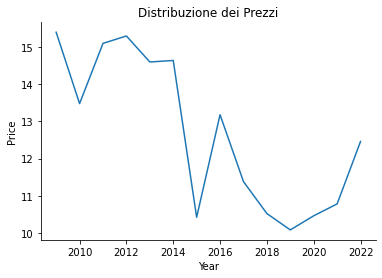

In [22]:
fig, ax = plt.subplots()
plt.plot(annual_price['Year'], annual_price['Price'])
plt.title("Distribuzione dei Prezzi")
plt.ylabel("Price")
plt.xlabel("Year")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Come si nota dal grafico il prezzo è molto variabile ma con una tendenza ad un prezzo più alto negli anni precedenti al 2014

<AxesSubplot:title={'center':'Price'}, xlabel='Year'>

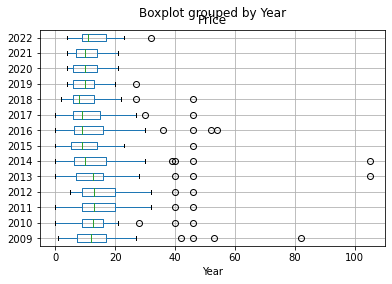

In [23]:
book.boxplot(column='Price', by='Year', vert = False)

Utilizzando anche un grafico boxplot vediamo come il range di prezzo è maggiore dal 2009 al 2014 per poi stabilizzarsi senza avere gap di prezzo troppo elevati

Una volta fatte queste considerazioni preliminari sul prezzo dei bestSeller capiamo la cosa più importante, ovvero se il genere incide su di esso:

Per far ciò applichiamo un T-Test

Possiamo confermare quanto appena detto attraverso un T-test:

H0: i libri "Non Fiction" costano di più rispetto a quelli "Fiction"

H1:i libri "Non Fiction" costano di meno rispetto a quelli "Fiction"

In [24]:
Fiction_book = np.where(book['Genre']=="Fiction")[0]
print("Libri fiction: " + str(len(Fiction_book)))
Nfiction_book = np.where(book['Genre']=="Non Fiction")[0]
print("Libri Non Fiction: " + str(len(Nfiction_book)))
campione_fict = book['Price'][Fiction_book].values[0:70].astype(int)
print("un campione di prezzo dalla categoria fiction: " + str(campione_fict.shape))
print("Prezzo medio del campione Fiction: " + str(np.mean(campione_fict)))
campione_nfict = book['Price'][Nfiction_book]
print("un campione dalla categoria Non Fiction: " + str(campione_nfict.shape))
print("Prezzo medio del campione Non Fiction: " + str(np.mean(campione_nfict)))

Libri fiction: 312
Libri Non Fiction: 388
un campione di prezzo dalla categoria fiction: (70,)
Prezzo medio del campione Fiction: 12.67142857142857
un campione dalla categoria Non Fiction: (388,)
Prezzo medio del campione Non Fiction: 14.337628865979381


In [25]:
t_statistic, p_value = stats.ttest_1samp(a= campione_nfict, popmean= campione_fict.mean(),alternative="less")
print(t_statistic)
print(p_value)

2.9771332331556124
0.9984537336734534


Usando sempre lo stesso intervallo di confidenza dello 0.95 vediamo come il livello di significatività è più basso del p-value e per questo posso accettare l'ipotesi H0: i libri Non Fiction costano di più

Possiamo dimostrare l'affidabilità di questo T-test con delle semplici funzioni:

In [26]:
book.groupby('Genre')[['Price']].mean().reset_index()

,Genre,Price
0,Fiction,10.663462
1,Non Fiction,14.337629


Il prezzo dei libri "Non Fiction" è più alto rispetto a quelli Fiction, in media di quasi quattro euro

<AxesSubplot:xlabel='Year', ylabel='Price'>

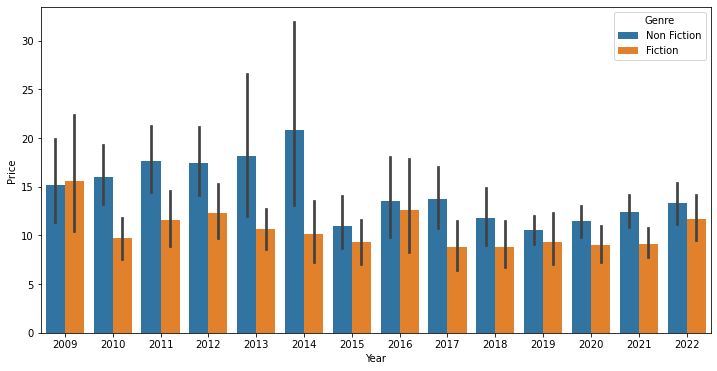

In [27]:
plt.figure(figsize=(12,6))
sns.barplot(data=book, x='Year', y='Price', hue='Genre')

Utilizzando la libreria seaborn che offre grafici molto precisi possiamo vedere come il prezzo dei libri "non fiction" è solitamente più alto rispetto a quello dei libri Fiction in ogni anno

Adesso vediamo, attraverso la libreria sklearn, come il prezzo potrebbe variare negli anni a venire prendendo come dati per la predizione quelli che abbiamo degli anni precedenti

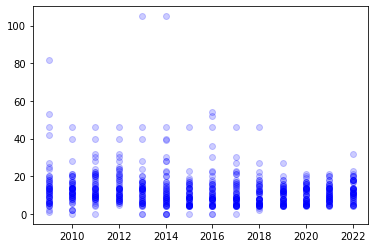

In [28]:
features = ['Year'] 
x=book[features]
y=book['Price']
plt.scatter(x, y, color='blue', alpha= 0.2)

Dividiamo i dati in training e test con la funzione apposita di sklean:

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(book.Year, book.Price, test_size=0.3)

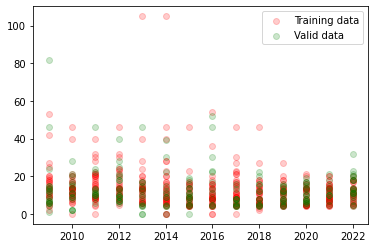

In [30]:
plt.scatter(X_train,y_train, label='Training data', color = 'r', alpha=0.2)
plt.scatter(X_valid,y_valid, label='Valid data', color = 'g', alpha=0.2)
plt.legend()
plt.show()

Una volta ottenuti i dati possiamo allenare l'oggetto di regressione lineare istanziato con il trainig set.

In [31]:
regressor = LinearRegression()
lin_reg = regressor.fit(X_train.values.reshape(-1,1), y_train.values)

E infine trovare la retta di regressione lineare:

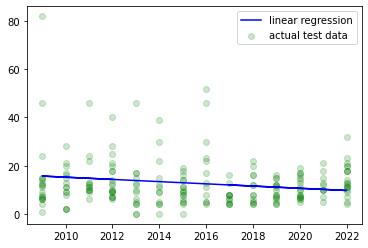

In [32]:
prediction = lin_reg.predict(X_valid.values.reshape(-1,1))
plt.plot(X_valid, prediction, label='linear regression', color='b')
plt.scatter(X_valid, y_valid, label='actual test data', color='g',alpha = 0.2)
plt.legend()
plt.show()

Attraverso la regressione lineare di sklear possiamo vedere come il prezzo tende sempre più o meno sul valore medio di 13/14 euro ma tende a scendere lentamente negli anni

In [33]:
lin_reg.predict(np.array([[2023]]))[0]

9.255048258941201

Ad esempio attraverso la funzione predict di sklear possiamo vedere come nel 2023 la media di prezzo dei best seller di amazon sarà tendente sui 9.3 euro

Adesso utilizzo tre funzioni di sklearn per calcolare tre metriche sul modello di regressione lineare appena fatto:

Questo ci servirà per capire se la regressione lineare appena fatta è affidabile o no

In [34]:
y_pred = regressor.predict(X_valid.values.reshape(-1,1))

In [35]:
print ('MAE:', metrics.mean_absolute_error(y_valid, y_pred))
print ('MSE:', metrics.mean_squared_error(y_valid, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

MAE: 6.649606001128952
MSE: 97.10703091002253
RMSE: 9.854289974930843


Determiniamo adesso il modello nullo:

In [36]:
mean_Price = book['Price'].mean()

null_model_y = [mean_Price] * book.shape[0]

# valutate il modello nullo usando le funzioni implementate 
print ('MAE:', metrics.mean_absolute_error(y, null_model_y))
print ('MSE:', metrics.mean_squared_error(y, null_model_y))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y, null_model_y)))

MAE: 6.122857142857143
MSE: 98.16999999999997
RMSE: 9.908077512817508


Come possiamo vedere i valori delle metriche derivate dal nostro modello di regressione lineare sono leggermente più basse di quelle derivate dal modello nullo con la media dei valori.

Per questo possiamo dire che il modello lineare è in linea di massima affidabile ma la poca differenza tra le due metriche definisce l'anno una features inadatta a stimare il prezzo di un libro.

In [37]:
book[['Year', 'Price']].corr()

,Year,Price
Year,1.000000,-0.155266
Price,-0.155266,1.000000


Questa informazione appena ricavata dalle metriche non è a noi nuova, infatti era già a nostra conoscenza il fatto che la correlazione tra anno e prezzo è molto bassa.

Purtroppo ogni features del nostro dataset ha una pessima correlazione con il prezzo, quindi risulta difficile trovare qualcosa che permette di stimare con precisione il prezzo con un modello di regressione lineare.

Possiamo comunque, attraverso la stima dell'errore RMSE, capire quale features potrebbe essere più utile per stimare il prezzo.

Per farlo abbiamo bisogno di un dataframe senza le colonne qualitative ovvero name,author ecc.

In [38]:
df = book.copy()
df.drop(['Name', 'Author', 'Price', 'Genre'], axis=1, inplace=True)
#df

In [39]:
def RMSE (y_pred,y_true):

  #codice qui
  return np.sqrt((1/y_pred.shape[0])*np.sum((y_pred - y_true)**2))

In [40]:
for i in range(0,df.shape[1]):
    features = list(df.columns)[0:i+1]
    features = df.columns[i]
    x = df[[features]]
    y = book['Price']
    regressor = LinearRegression()
    x_train, x_valid, y_train, y_valid = train_test_split(x, y)
    lin_reg = regressor.fit(x_train, y_train)
    y_pred = lin_reg.predict(x_valid)
    print('RMSE:',RMSE(y_pred,y_valid))

features = np.asarray(list(df.columns))[0:i+1]
print(features)
x = df[features]
y = book['Price']
regressor = LinearRegression()
x_train, x_valid, y_train, y_valid = train_test_split(x, y)
lin_reg = regressor.fit(x_train,y_train)
y_pred = lin_reg.predict(x_valid)
print('RMSE:',RMSE(y_pred,y_valid))


RMSE: 8.911516598109252
RMSE: 10.307675607093179
RMSE: 9.649971830970605
['User Rating' 'Reviews' 'Year']
RMSE: 9.309011609144916


Come possiamo vedere l'errore è variabile e anche combinando diverse feature non si abbassa in maniera significativa.

In definitiva fare una regressione lineare molto precisa per predire l'andamento del prezzo risulta davvero difficile per la poca correlazione che c'è tra le features

## STUDIO DEL NOME

L'interesse di un utente verso un libro potrebbe dipendere anche da alcune parole utilizzate che portano a comprarlo, per trovare le parole utilizzate quindi utilizziamo una libreria specifica (wordcloud)

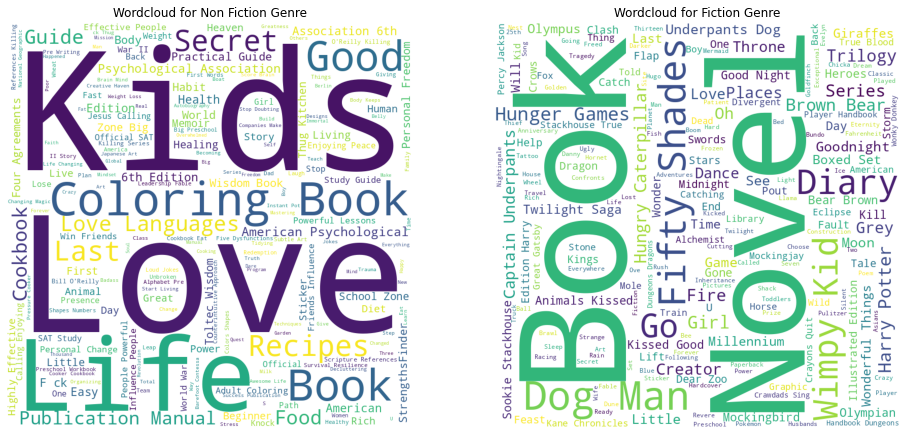

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(16,16))# plotting two subplots 
fict = WordCloud(background_color='white',width=800, height=800).generate(' '.join(book['Name'][book['Genre']=='Non Fiction']))
non_fict= WordCloud(background_color='white',width=800, height=800).generate(' '.join(book['Name'][book['Genre']=='Fiction']))
ax[0].imshow(fict)
ax[0].axis('off')
ax[0].set_title('Wordcloud for Non Fiction Genre')

ax[1].imshow(non_fict)
ax[1].axis('off')
ax[1].set_title('Wordcloud for Fiction Genre')

plt.show()

Queste sono tra le parole che vengono più utilizzate nei libri

Vediamo attraverso la regressione logistica se c'è della correlazione tra l'utilizzo di certe parole e, ad esempio, la valutazione

Prendo come punto di riferimento come "buona valutazione" tutte quelle che sono più grandi della valutazione media

In [42]:
x = book.Name
y = book['User Rating'] > book['User Rating'].mean()

print(x.shape)
print(y.shape)

(700,)
(700,)


A questo punto conto il numero di parole ricavate ed elimino dai titoli tutte le parole inglesi come an,the,a ecc.

In [43]:
vect = CountVectorizer(stop_words='english')

E trasformo quello appena ottenuto in una document term matrix

In [44]:
x_dtm = vect.fit_transform(x)
print(x_dtm.shape)

(700, 1265)


Estraggo i dati in modo casuale attraverso una libreria di sklear e li organizzo in insiemi di training e valutazione

In [45]:
x_train, x_test, y_train, y_test = ms.train_test_split(x_dtm, y, random_state=100)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(525, 1265)
(525,)
(175, 1265)
(175,)


Alleno il modello di regressione logistica 

In [46]:
lr = LogisticRegression()

Model = lr.fit(x_train, y_train)

In [47]:
lr.score(x_test, y_test)

0.7942857142857143

Lo score è di 0.79 e questo significa che la scelta di alcune parole nel titolo è strettamente correlata ad una valutazione più alta

Per questo potrebbe essere opportuno utilizzare alcune parole presenti nel grafico sviluppato con worcloud per attirare l'utente medio di amazon a comprare un libro.

## CONCLUSIONI

A seguito di quello appena scoperto possiamo affermare che: 
+ il genere preferito in generale è quello "non fiction", essendo appunto molto grande, potrebbe infatti essere un saggio come un libro di cucina o ancora una biografia di un personaggio famoso.
+ il prezzo consigliato per vendere un libro negli anni a venire è attorno ai 9 euro
+ esistono alcune parole che attirano più l'utente e queste sono diverse per genere

Quindi concludendo il nostro studio possiamo rispondere alla domanda posta all'inizio:
Una ipotetica casa editrice considerati i best seller di amazon dal 2009 al 2022 per puntare a quella utenza dovrebbe vendere libri non di narrativa con un prezzo che si aggira attorno ai 9 euro

Tuttavia, ad eccezion fatta per le reviews per anno, la correlazione tra le colonne del nostro dataset è così bassa da rendere quasi impossibile fare stime certe su come si comporterà la vendita di libri su amazon negli anni a venire